## K-Means Clustering - Customer Segmentation

**Overview**<br>
Data is downloaded from - https://archive.ics.uci.edu/ml/datasets/online+retail

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and recommendations

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# read the dataset
retail_df = pd.read_csv(r"C:\Users\HP\Downloads\PythonTest\customer_purchases.csv")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [4]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [5]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [6]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [8]:
# monetary
amount = retail_df.groupby('CustomerID')['amount'].sum()
amount = amount.reset_index()
amount.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# frequency
# count function gets the count of each item
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].nunique()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [10]:
# merge the two dfs
grouped_df = pd.merge(amount, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,7
2,12348.0,1797.24,4
3,12349.0,1757.55,1
4,12350.0,334.40,1


In [17]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60


In [22]:
# recency
# convert to datetime

# retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%m-%d-%Y %H:%M')

format_string = "%m/%d/%Y %H:%M"

retail_df['InvoiceDate'] = datetime.strptime(retail_df['InvoiceDate'], format_string)

TypeError: strptime() argument 1 must be str, not Series

In [23]:
format_string = "%m/%d/%Y %H:%M"
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format=format_string)

In [24]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [25]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [26]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [27]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,7,1 days 20:58:00
2,12348.0,1797.24,4,74 days 23:37:00
3,12349.0,1757.55,1,18 days 02:59:00
4,12350.0,334.40,1,309 days 20:49:00


In [28]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,7,1
2,12348.0,1797.24,4,74
3,12349.0,1757.55,1,18
4,12350.0,334.40,1,309


In [29]:
# rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

In [30]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.329362,2.322023
1,0.293432,0.206102,-0.893733
2,-0.012316,-0.115176,-0.169196
3,-0.017146,-0.436455,-0.725005
4,-0.190312,-0.436455,2.163220


# 4. Modelling

In [31]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [32]:
kmeans.labels_

array([2, 0, 0, ..., 0, 0, 0])

In [33]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### Elbow Curve Method

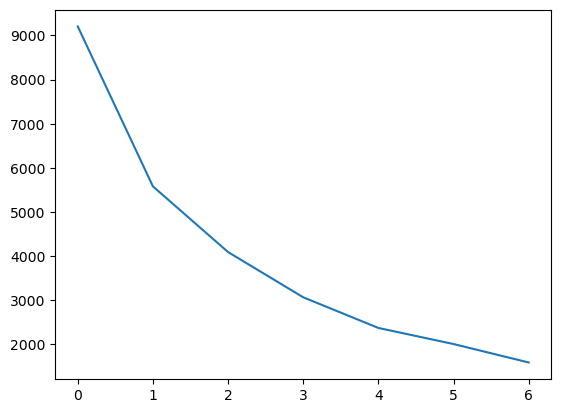

In [34]:
# elbow-curve
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.9189178930238121
For n_clusters=3, the silhouette score is 0.5816398582462883
For n_clusters=4, the silhouette score is 0.6142804196098184
For n_clusters=5, the silhouette score is 0.5979767726965929
For n_clusters=6, the silhouette score is 0.5150520959066113
For n_clusters=7, the silhouette score is 0.5736900970958255
For n_clusters=8, the silhouette score is 0.5080989636320608


In [36]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [37]:
kmeans.labels_

array([0, 1, 1, ..., 1, 1, 1])

In [38]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,7,1,1
2,12348.0,1797.24,4,74,1
3,12349.0,1757.55,1,18,1
4,12350.0,334.40,1,309,0


<Axes: xlabel='cluster_id', ylabel='amount'>

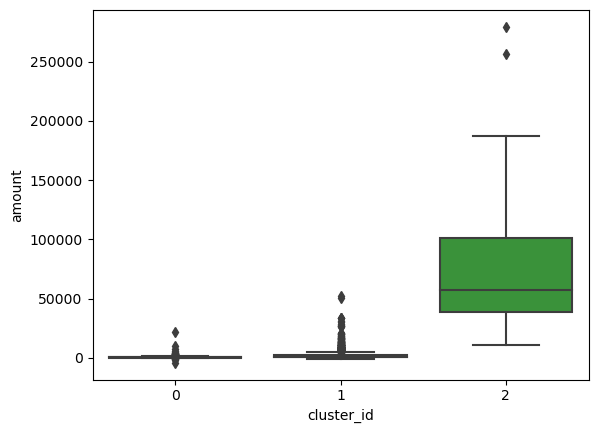

In [39]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

<div style="font-family:verdana;">
    <h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
    * <i> Cluster <code>2</code> represents high monetary customers.</i><br>
    * <i> Cluster <code>0</code> and <code>1</code> has high overlap.</i><br>
    </div>
</div>

<Axes: xlabel='cluster_id', ylabel='frequency'>

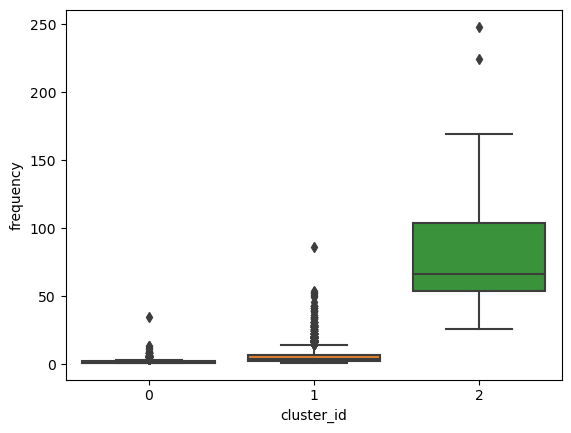

In [40]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

<div style="font-family:verdana;">
    <h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
    * <i> Cluster <code>2</code> represents high frequency customers.</i><br>
    * <i> Cluster <code>0</code> and <code>1</code> has high overlap.</i><br>
    </div>
</div>

<Axes: xlabel='cluster_id', ylabel='recency'>

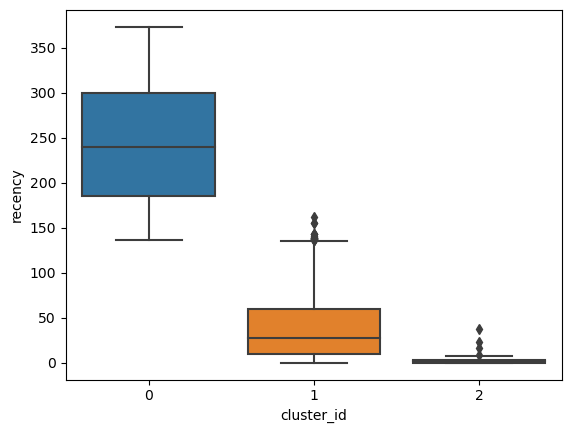

In [41]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

<div style="font-family:verdana;">
    <h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
    * <i> Cluster <code>2</code> represents high recency customers.</i><br>
    * <i> Cluster <code>0</code> represents least recent.</i><br>
    </div>
</div>

# 5. Treating the Outliers

In [42]:
grouped_df.describe()

,CustomerID,amount,frequency,recency,cluster_id
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1898.459701,5.075480,91.047118,0.751601
std,1722.390705,8219.345141,9.338754,100.765435,0.444144
min,12346.000000,-4287.630000,1.000000,0.000000,0.000000
25%,13812.750000,293.362500,1.000000,16.000000,0.000000
50%,15300.500000,648.075000,3.000000,49.000000,1.000000
75%,16778.250000,1611.725000,5.000000,142.000000,1.000000
max,18287.000000,279489.020000,248.000000,373.000000,2.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x2021821b490>,
 'caps': [<matplotlib.lines.Line2D at 0x20218270dd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2021821a7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x20218272410>],
 'fliers': [<matplotlib.lines.Line2D at 0x20218272f10>],
 'means': []}

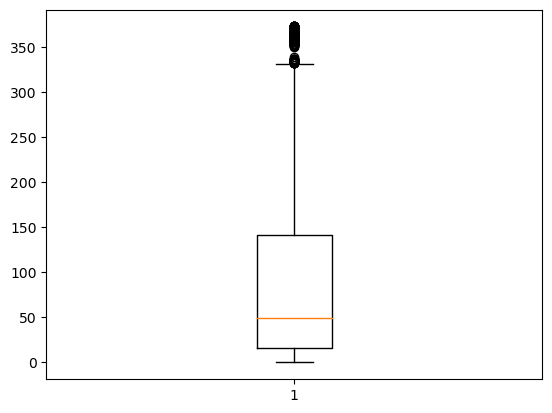

In [43]:
plt.boxplot(grouped_df['recency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x202181b7150>,
 'caps': [<matplotlib.lines.Line2D at 0x20217573bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x202181b66d0>],
 'medians': [<matplotlib.lines.Line2D at 0x202181c1c90>],
 'fliers': [<matplotlib.lines.Line2D at 0x202182671d0>],
 'means': []}

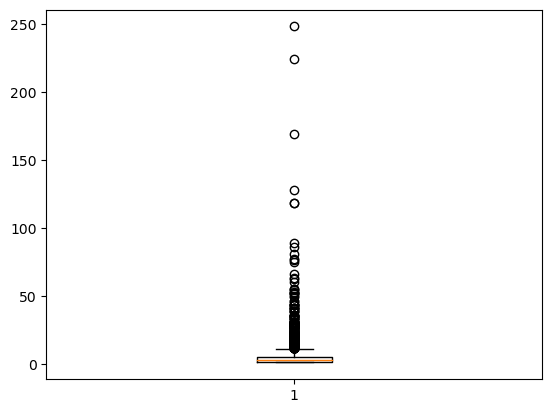

In [44]:
plt.boxplot(grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x20218372290>,
 'caps': [<matplotlib.lines.Line2D at 0x20218373a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x20218371990>],
 'medians': [<matplotlib.lines.Line2D at 0x20218369090>],
 'fliers': [<matplotlib.lines.Line2D at 0x20216bb1ad0>],
 'means': []}

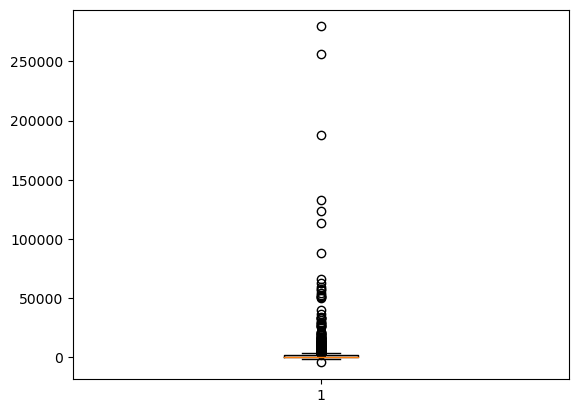

In [45]:
plt.boxplot(grouped_df['amount'])

In [46]:
# two types of outliers:
# - statistical
# - domain specific

In [47]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.10)
Q3 = grouped_df.amount.quantile(0.90)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.10)
Q3 = grouped_df.recency.quantile(0.90)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.10)
Q3 = grouped_df.frequency.quantile(0.90)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

In [48]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4209, 3)

In [49]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.844245,-0.498797,2.280654
1,2.423353,0.801164,-0.919107
2,0.518321,0.021187,-0.198173
3,0.488230,-0.758789,-0.751218
4,-0.590722,-0.758789,2.122641


# 6. Modelling

## Finding the Optimal Number of Clusters

### SSD

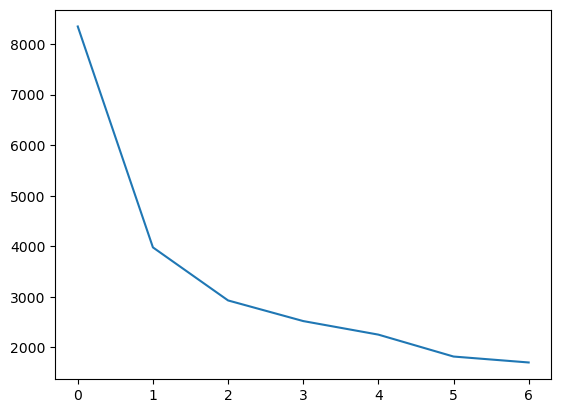

In [50]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [51]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.4979580758288508
For n_clusters=3, the silhouette score is 0.49030867779024295
For n_clusters=4, the silhouette score is 0.36712959304228043
For n_clusters=5, the silhouette score is 0.39632342508052804
For n_clusters=6, the silhouette score is 0.40012931281106506
For n_clusters=7, the silhouette score is 0.3790888654495915
For n_clusters=8, the silhouette score is 0.3859118719764197


In [52]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [53]:
kmeans.labels_

array([1, 0, 2, ..., 2, 0, 2])

In [54]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,7,1,0
2,12348.0,1797.24,4,74,2
3,12349.0,1757.55,1,18,2
4,12350.0,334.40,1,309,1


In [55]:
grouped_df.cluster_id.value_counts()

cluster_id
2    2503
1    1051
0     655
Name: count, dtype: int64

<Axes: xlabel='cluster_id', ylabel='amount'>

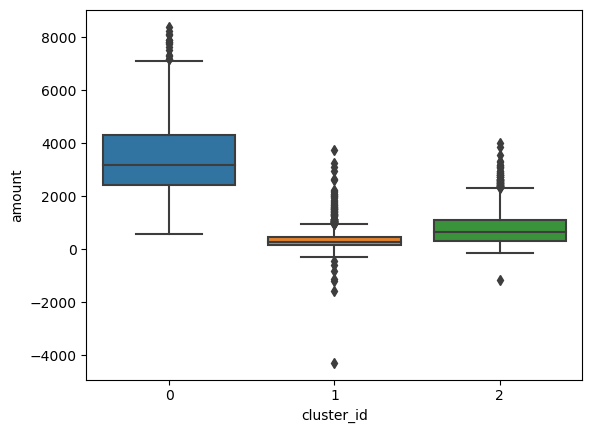

In [56]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

<div style="font-family:verdana;">
    <h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
    * <i> Cluster <code>2</code> represents high monetary customers.</i><br>
    * <i> Cluster <code>1</code> represents least monetary customers.</i><br>
    </div>
</div>

<Axes: xlabel='cluster_id', ylabel='frequency'>

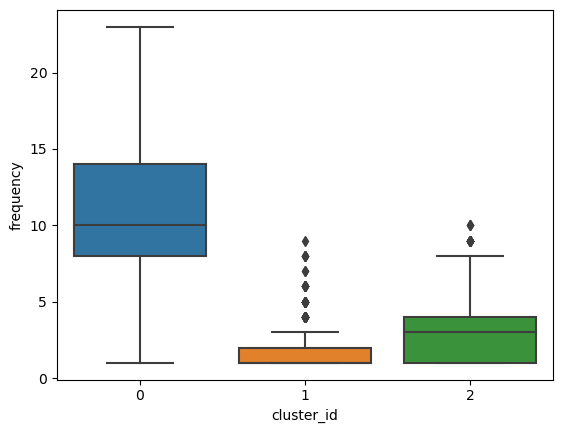

In [57]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

<div style="font-family:verdana;">
    <h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
    * <i> Cluster <code>2</code> represents high frequency customers.</i><br>
    * <i> Cluster <code>1</code> represents least frequency customers.</i><br>
    </div>
</div>

<Axes: xlabel='cluster_id', ylabel='recency'>

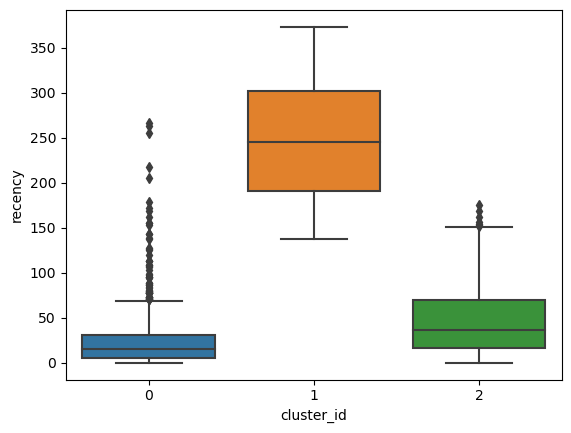

In [58]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

<div style="font-family:verdana;">
    <h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
    * <i> Cluster <code>2</code> represents high recency customers.</i><br>
    * <i> Cluster <code>1</code> represents least recency customers.</i><br>
    </div>
</div>